# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit,substring, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor,split
from pyspark.sql.functions import from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler ,StandardScaler,PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline 
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create a Spark session 
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load dataset
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

df.head(1)
#df.printSchema()

# Explore missing values in data
def count_missing(df, col1):
    """
    A helper function which count how many missing values in a column of the dataset.
    """
    return df.filter((isnan(df[col1])) | (df[col1].isNull()) | (df[col1] == "")).count()

print("missing column values count:\n")
for col1 in df.columns:
    missing_count = count_missing(df, col1)
    if missing_count > 0:
        print("{}: {}".format(col1, missing_count))

missing column values count:

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [4]:
print("row count before cleaning:")
df.count()
# filtering out missing userids
df = df.filter((df.userId != "") | (df.sessionId != ""))
print("row count after cleaning:")
df.count()

row count before cleaning:
row count after cleaning:


278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# observation
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Spark SQL EDA 

In [6]:
#Spark SQL data EDA 
df.createOrReplaceTempView("df_table")

# Get number of users 
spark.sql('''
          SELECT  COUNT(DISTINCT userID) 
          FROM df_table 
          '''
          ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   225|
+----------------------+



In [7]:
# Get number of sessions 
spark.sql('''
          SELECT  COUNT(DISTINCT sessionID) 
          FROM df_table 
          '''
          ).show()

+-------------------------+
|count(DISTINCT sessionID)|
+-------------------------+
|                     2312|
+-------------------------+



In [8]:
# Get levels
spark.sql('''
          SELECT  DISTINCT level 
          FROM df_table 
          '''
          ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
# Get gender count
spark.sql('''
          SELECT  gender,count(distinct userID)
          FROM df_table 
          group by 1
          '''
          ).show()

+------+----------------------+
|gender|count(DISTINCT userID)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



In [10]:
# Get values of status
spark.sql('''
          SELECT  DISTINCT status 
          FROM df_table 
          '''
          ).show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [11]:
#page info
spark.sql('''
          SELECT  DISTINCT page 
          FROM df_table 
          order by 1
          '''
          ).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [12]:
#gender distribution for Cancellation
spark.sql('''
          SELECT gender, count(distinct userID) as churn_count
          FROM df_table 
          where page = "Cancellation Confirmation"
          group by 1
          '''
          ).show()

+------+-----------+
|gender|churn_count|
+------+-----------+
|     F|         20|
|     M|         32|
+------+-----------+



In [13]:
#Cancellation happened hours during the day
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))
churn_in_hour = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_cancle_hour
          FROM df_table
          where page = "Cancellation Confirmation"
          GROUP BY hour
          ORDER BY plays_cancle_hour DESC
          '''
          ).show()

+----+-----------------+
|hour|plays_cancle_hour|
+----+-----------------+
|   7|                6|
|  19|                5|
|  15|                4|
|  16|                4|
|  22|                3|
|  20|                3|
|   0|                3|
|  18|                3|
|  21|                3|
|  11|                2|
|   3|                2|
|  17|                2|
|   4|                2|
|  12|                2|
|   8|                1|
|   5|                1|
|  23|                1|
|  10|                1|
|  14|                1|
|   1|                1|
+----+-----------------+
only showing top 20 rows



In [14]:
#songs played distribution in hour
songs_in_hour = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM df_table
          WHERE page = "NextSong"
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
          ).show(24)

+----+--------------+
|hour|plays_per_hour|
+----+--------------+
|   0|          9062|
|   1|          8388|
|   2|          8336|
|   3|          8355|
|   4|          8147|
|   5|          8178|
|   6|          8054|
|   7|          8091|
|   8|          8253|
|   9|          8498|
|  10|          8882|
|  11|          8830|
|  12|          9326|
|  13|          9644|
|  14|         10494|
|  15|         11354|
|  16|         11636|
|  17|         11460|
|  18|         11124|
|  19|         10930|
|  20|         10856|
|  21|         10458|
|  22|         10122|
|  23|          9630|
+----+--------------+



In [15]:
#top 5 most played artist

spark.sql("SELECT Artist, COUNT(Artist) AS plays \
        FROM df_table \
        GROUP BY Artist \
        ORDER BY plays DESC \
        LIMIT 5").show()

+--------------------+-----+
|              Artist|plays|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
+--------------------+-----+



In [15]:
# Create a churn userID
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM df_table \
                    WHERE Page = "Cancellation Confirmation"')

# non churn userID
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM df_table \
                      WHERE userId NOT IN (SELECT DISTINCT userId \
                      FROM df_table WHERE Page = "Cancellation Confirmation")')

churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Check user count match with ealier user row count
churn_df.count()

225

In [16]:
# Distribution of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,173
1,1,52


+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
+-----+------+-----+



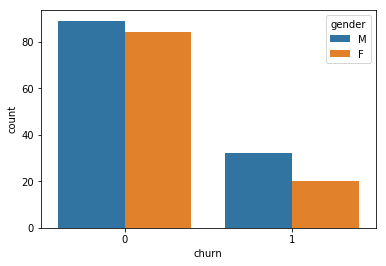

In [17]:
# Join our churn to full dataset to add churn column
joined_df = df.join(churn_df, on='userId')

#compare gender difference
joined_df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"])\
.count().sort("churn", desc("gender")).show()

df_new = joined_df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_new)

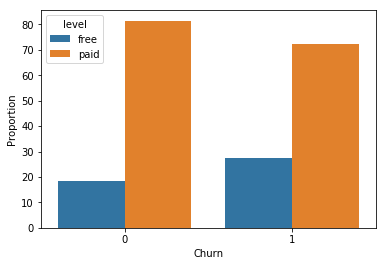

In [18]:
#compare level difference
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_left')['count_left']/level_df.join(churn_sum, on = 'churn', lsuffix='_left')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df)
g.set(xlabel='Churn', ylabel="Proportion")
plt.show();

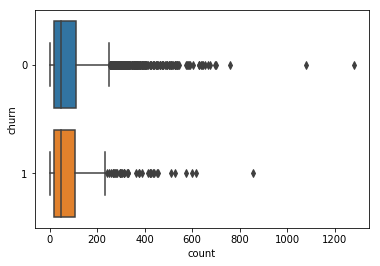

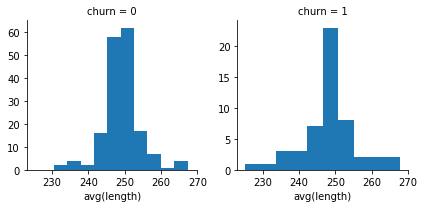

In [19]:
#distribution in each session
df_pd = joined_df.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn',orient="h",  data=df_pd)

# get the average length 
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

# visualize the distribution of length between two groups of users
g = sns.FacetGrid(length_df, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

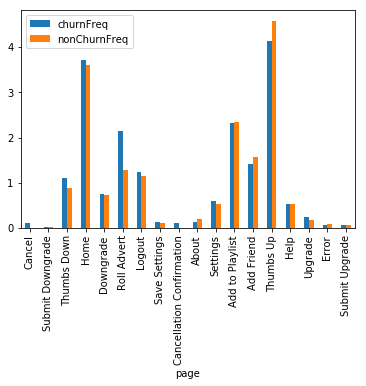

In [20]:
churn_count = joined_df.filter(joined_df.churn==1).count()
no_churn_count = joined_df.filter(joined_df.churn==0).count()

df_temp1 = joined_df.filter(joined_df.churn==1).filter(joined_df.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("churnFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = joined_df.filter(joined_df.churn==0).filter(joined_df.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("nonChurnFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")


In [21]:
# create  state column
joined_df = joined_df.withColumn('state', substring(joined_df['location'], -2, 3))
# the ts column is actually a unix timestamp, which we convert to a date format
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

joined_df.dropDuplicates(['userId','churn', 'state']).groupBy(['churn', 'state']).count()\
.where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

joined_df.dropDuplicates(['userId','churn', 'state']).groupBy(['churn', 'state']).count()\
.where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA|    6|
|    1|   PA|    5|
|    1|   FL|    3|
|    1|   TX|    3|
|    1|   MI|    3|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|   27|
|    0|   PA|   13|
|    0|   TX|   13|
|    0|   FL|   11|
|    0|   WI|    9|
+-----+-----+-----+
only showing top 5 rows



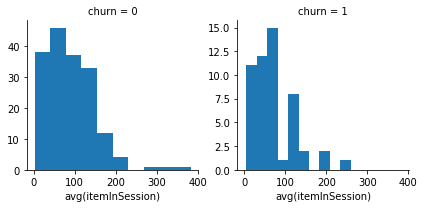

In [22]:
# visualize itemInSession distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

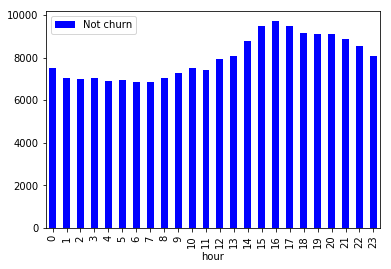

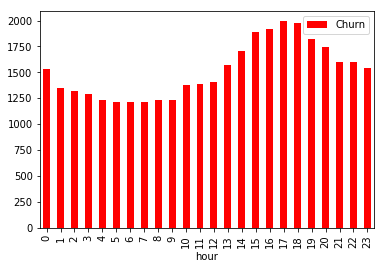

In [23]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
joined_df = joined_df.withColumn("hour", get_hour(joined_df.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
joined_df = joined_df.withColumn("weekday", get_weekday(joined_df.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
joined_df = joined_df.withColumn("day", get_day(joined_df.ts))

def plot_by_churnTime(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = joined_df.filter(joined_df.page == "NextSong").groupby("churn", time).count().orderBy(joined_df[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')

plot_by_churnTime("hour")


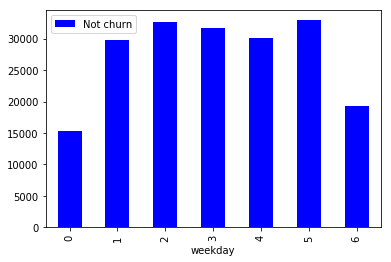

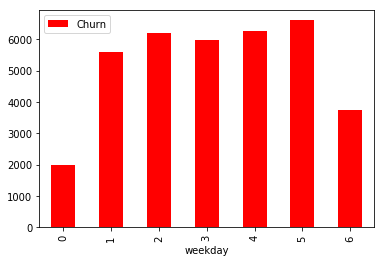

In [24]:
plot_by_churnTime("weekday")

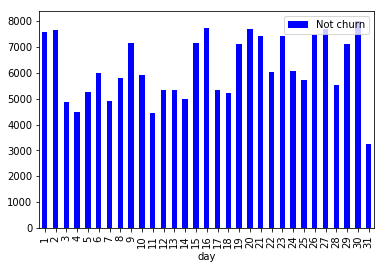

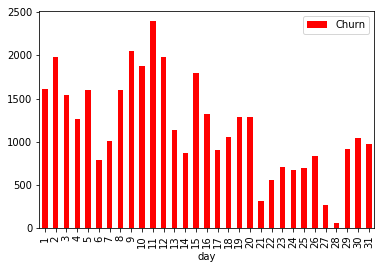

In [25]:
plot_by_churnTime("day")

In [26]:
#number of days since registration
user_max_ts = joined_df.groupby("userId").max("ts").sort("userId")
user_reg_ts = joined_df.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("registDay"))

user_reg_days.show(5)

+------+------------------+
|userId|         registDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [27]:
def feature_engineering(filepath):
    '''
    Create necessary features to use machine learning algorithms.
    First loads data set from file
    Inputs
        filepath (str) - path to json dataset on file       
    Outputs
        data - feauture engineered dataset
    '''
    #load  and clean data
    df = spark.read.json(filepath)  
    df = df.filter((df.userId != "") | (df.sessionId != ""))
    
    users = df.select('userId').dropDuplicates()
    
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    Roll_Advert =  udf(lambda x: int(x=='Roll Advert'), IntegerType())
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    male = udf(lambda x: int(x=='M'), IntegerType())
    female = udf(lambda x: int(x=='F'), IntegerType())

    
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .withColumn('roll_advert', Roll_Advert('page'))\
        .select(['userId', 'downgraded', 'cancelled',  'visited_downgrade','roll_advert'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')\
        .withColumnRenamed('sum(roll_advert)', 'roll_advert')
    
      #avg daily visits to help /Error site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    dailyErrors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')
    

    user_level = df.select('userId', 'level','gender')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')\
        .withColumn('male', male('gender'))\
        .withColumn('female', female('gender')).drop('gender')
    
    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')
    
    avgThumbsDown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown')
    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    #number of days since registration
    user_max_ts = df.groupby("userId").max("ts").sort("userId")
    user_reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")
    user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId)\
        .select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("registDay"))
    
    #average song played length
    songplaylength = df.filter(df.page=='NextSong')\
        .select('userId', 'length')\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(length)', 'avg_songplaylength')
    
    # put all the features together
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(dailyErrors, on='userId')\
        .join(user_level, on='userId')\
        .join(avgThumbsUp, on='userId')\
        .join(avgThumbsDown, on='userId')\
        .join(numFriends, on='userId')\
        .join(user_reg_days, on='userId')\
        .join(songplaylength, on='userId')
  
    return df

In [28]:
from pyspark.ml.feature import MinMaxScaler
def feature_scaling(df):
    '''
    Put the features into a vector and normalize it by scaler
    Inputs
        data - feauture engineered dataset      
    Outputs
        normalized dataframe
    '''   
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
data = feature_engineering("mini_sparkify_event_data.json")
data = feature_scaling(data)
data.persist()

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_downgrade: bigint, roll_advert: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, male: int, female: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, registDay: double, avg_songplaylength: double, label: double, feature_vec: vector, features: vector]

In [30]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- downgraded: long (nullable = true)
 |-- cancelled: long (nullable = true)
 |-- visited_downgrade: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- dailyHelpVisits: double (nullable = true)
 |-- dailyErrors: double (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- male: integer (nullable = true)
 |-- female: integer (nullable = true)
 |-- avgThumbsUp: double (nullable = true)
 |-- avgThumbsDown: double (nullable = true)
 |-- numFriends: long (nullable = false)
 |-- registDay: double (nullable = true)
 |-- avg_songplaylength: double (nullable = true)
 |-- label: double (nullable = true)
 |-- feature_vec: vector (nullable = true)
 |-- features: vector (nullable = true)



In [31]:
train, test = data.randomSplit([0.7, 0.3], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
roc = BinaryClassificationEvaluator(metricName='areaUnderROC')

Training Dataset Count: 135
Test Dataset Count: 61


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
def custom_evaluation(pred, model_name):   
    '''  
    Inputs
        predictions from model, model name
    '''
    pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
    pr_auc=pr.evaluate(pred)
    
    print(f"{model_name} \nPR AUC = {pr_auc}")
    
    predictionRDD = pred.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionRDD)

    # Summary stats
    print("Precision = %s" % metrics.precision())
    print("F1 measure = %s" % metrics.fMeasure())
    print("Accuracy = %s" % metrics.accuracy)
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Predicted Label', ylabel='True Label', title='CM')
    plt.show()

Logistic Regression 
PR AUC = 0.19672131147540983
Precision = 0.8032786885245902
F1 measure = 0.8032786885245902
Accuracy = 0.8032786885245902


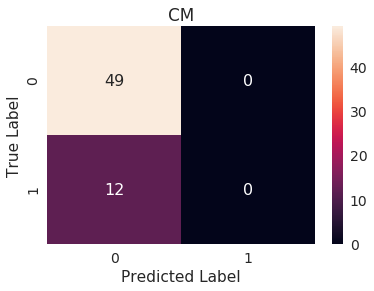

In [33]:
#logistic regression model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(test)
custom_evaluation(lr_preds, 'Logistic Regression')


SVM 
PR AUC = 0.5584575606490263
Precision = 0.8032786885245902
F1 measure = 0.8032786885245902
Accuracy = 0.8032786885245902


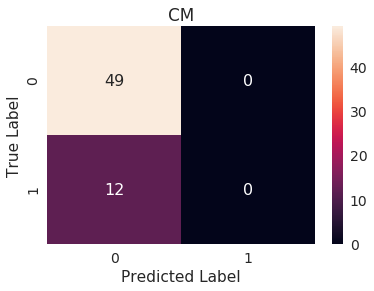

In [34]:
#SVM
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(test)
custom_evaluation(svm_preds, 'SVM')

Random Forest 
PR AUC = 0.8488151452305863
Precision = 0.8852459016393442
F1 measure = 0.8852459016393442
Accuracy = 0.8852459016393442


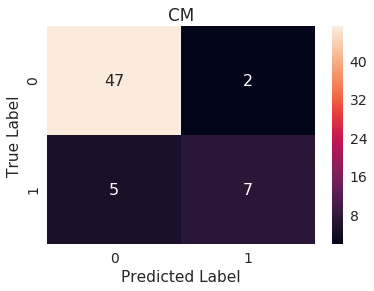

In [35]:
#random forest classifier model
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(test)
custom_evaluation(rf_preds, 'Random Forest')

Gradient Boosted Trees 
PR AUC = 1.0
Precision = 0.9836065573770492
F1 measure = 0.9836065573770492
Accuracy = 0.9836065573770492


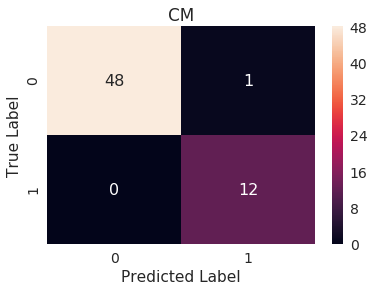

In [36]:
#gradient boosted trees 
gbtrees = GBTClassifier(maxIter=10)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(test)
custom_evaluation(gbtree_preds, 'Gradient Boosted Trees')

In [37]:
#featureImportances analysis
feature_cols = train.drop('userId', 'cancelled').columns
gb_fi_df = pd.DataFrame(gbtree_model.featureImportances.toArray(),columns=['importance'])
# Convert list of feature names to pandas column
gb_fi_df['feature'] = pd.Series(feature_cols)
# Sort the data based on feature importance
gb_fi_df.sort_values(by=['importance'], ascending=False, inplace=True)

# Inspect Results
gb_fi_df

,importance,feature
11,0.146075,numFriends
10,0.139718,avgThumbsDown
1,0.124101,visited_downgrade
12,0.106180,registDay
3,0.102902,dailyHelpVisits
2,0.101299,roll_advert
4,0.089672,dailyErrors
9,0.075129,avgThumbsUp
13,0.071378,avg_songplaylength
0,0.041900,downgraded


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.